In [1]:
import os
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
from sklearn.preprocessing import StandardScaler
import cv2
import wandb

/home/vera/miniconda3/envs/ails/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load jpeg images from a directory and convert them to numpy arrays
def load_images(directory):
    images = []
    for filename in glob.glob(directory + '/*.jpg'):
        img = Image.open(filename)
        img = np.array(img)
        images.append(img)
    return np.array(images)



def points_out_of_graph(data_embedded, data, x_axis_threshold, y_axis_theshold, x_over=True, y_over=True):
    if x_over:
        if y_over:
            indices = np.where((data_embedded[:, 0] > x_axis_threshold) & (data_embedded[:, 1] > y_axis_theshold))[0]
        else:
            indices = np.where((data_embedded[:, 0] > x_axis_threshold) & (data_embedded[:, 1] < y_axis_theshold))[0]
    else:
        if y_over:
            indices = np.where((data_embedded[:, 0] < x_axis_threshold) & (data_embedded[:, 1] > y_axis_theshold))[0]
        else:
            indices = np.where(data_embedded[:, 0] < x_axis_threshold)[0] & (data_embedded[:, 1] < y_axis_theshold)[0]


    points = data[indices]

    print(f"There are {len(points)} points\n")
    print(f"Indices of the points are: {indices}\n")
    return indices

def analyze_hsv(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hue, saturation, value = cv2.split(hsv_image)
    
    # Chroma is defined as the difference between the maximum and minimum RGB values
    r, g, b = cv2.split(image)
    chroma = np.maximum(np.maximum(r, g), b) - np.minimum(np.minimum(r, g), b)
    
    return hue, saturation, chroma


In [10]:
label_path = "/home/vera/Documents/AI/AILS-MICCAI-UWF4DR-Challenge/data/raw/UWF4DRChallengeData/Task 1 Image Quality Assessment/2. Groundtruths/1. Training.csv"
# Create a binary classification task with an SVM
y = np.loadtxt(label_path, delimiter=',', skiprows=1, usecols=1)

In [4]:
data_path1 = "/home/vera/Documents/AI/AILS-MICCAI-UWF4DR-Challenge/data/raw/UWF4DRChallengeData/Task 1 Image Quality Assessment/1. Images/1. Training"
data_path2 = "/home/vera/Documents/AI/AILS-MICCAI-UWF4DR-Challenge/data/raw/UWF4DRChallengeData/Task 2 Referable DR and Task 3 DME/1. Images/1. Training"
data1 = load_images(data_path1)
data2 = load_images(data_path2)
data = np.concatenate((data1, data2), axis=0)

In [6]:
n_samples, h, w, c = data.shape
flattened_images = data.reshape(n_samples, -1)


In [7]:

# Standardize the data
scaler = StandardScaler()
flattened_images_scaled = scaler.fit_transform(flattened_images)

In [8]:


# Apply PCA
n_components = 2  # Number of principal components to keep
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(flattened_images_scaled)

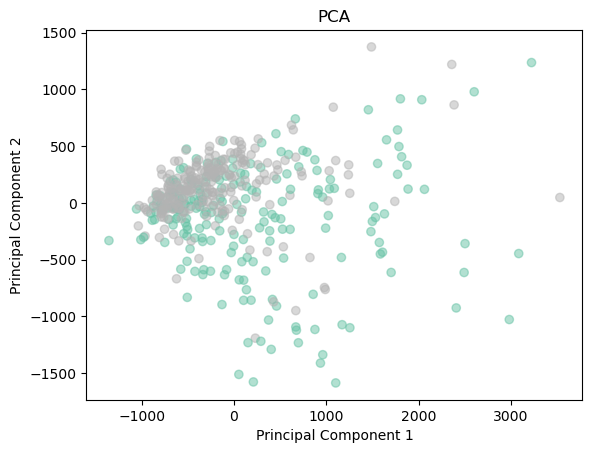

In [24]:
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=y, cmap='Set2', alpha=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.show()

In [19]:
points_out_of_graph(principal_components, data, 2000, 0, x_over=True, y_over=False)

There are 5 points

Indices of the points are: [ 15  52  75 109 149]



array([ 15,  52,  75, 109, 149])

In [ ]:
umap_model = umap.UMAP(n_components=2, n_neighbors=5)
umap_embedding = umap_model.fit_transform(flattened_images_scaled)



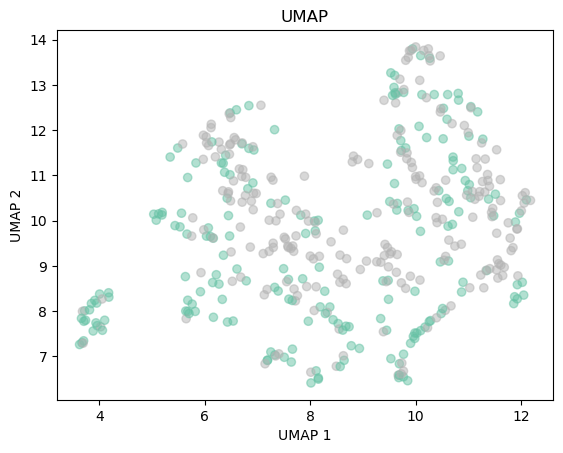

In [18]:
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=y, cmap='Set2', alpha=0.5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP')
plt.show()


In [ ]:
indices = points_out_of_graph(umap_embedding, data, 4.9, 0, x_over=False, y_over=True)


There are 0 points

Indices of the points are: []



In [29]:
zero = data[y == 0]
one = data[y == 1]

In [65]:
def plot_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 6))
    fig.suptitle(title)
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis('off')
        plt.colorbar()
    plt.show()#

def hsv(images):


    # Initialize lists to hold the extracted components
    hue_list = []
    saturation_list = []
    chroma_list = []

    # Process each image
    for img in images:
        hue, saturation, chroma = analyze_hsv(img)
        hue_list.append(hue)
        saturation_list.append(saturation)
        chroma_list.append(chroma)

    # Convert lists to numpy arrays for further analysis
    hue_array = np.array(hue_list)
    saturation_array = np.array(saturation_list)
    chroma_array = np.array(chroma_list)

    return hue_array, saturation_array, chroma_array



def plot_hsv(hue_array, saturation_array, chroma_array, titles:list, title:str):
    #plot the mean hue, saturation, and chroma

    plt.figure(figsize=(18, 6))
    plt.suptitle(title)
    plt.subplot(1, 3, 1)
    plt.imshow(hue_array, cmap='hsv')
    plt.title(titles[0])
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(saturation_array, cmap='gray')
    plt.title(titles[1])
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(chroma_array, cmap='gray')
    plt.title(titles[2])
    plt.colorbar()

    plt.show()


def mean_hsv(hue_array, saturation_array,chroma_array):
    # Calculate the mean of each component
    mean_hue = np.mean(hue_array, axis=0)
    mean_saturation = np.mean(saturation_array, axis=0)
    mean_chroma = np.mean(chroma_array, axis=0)

    return mean_hue, mean_saturation, mean_chroma

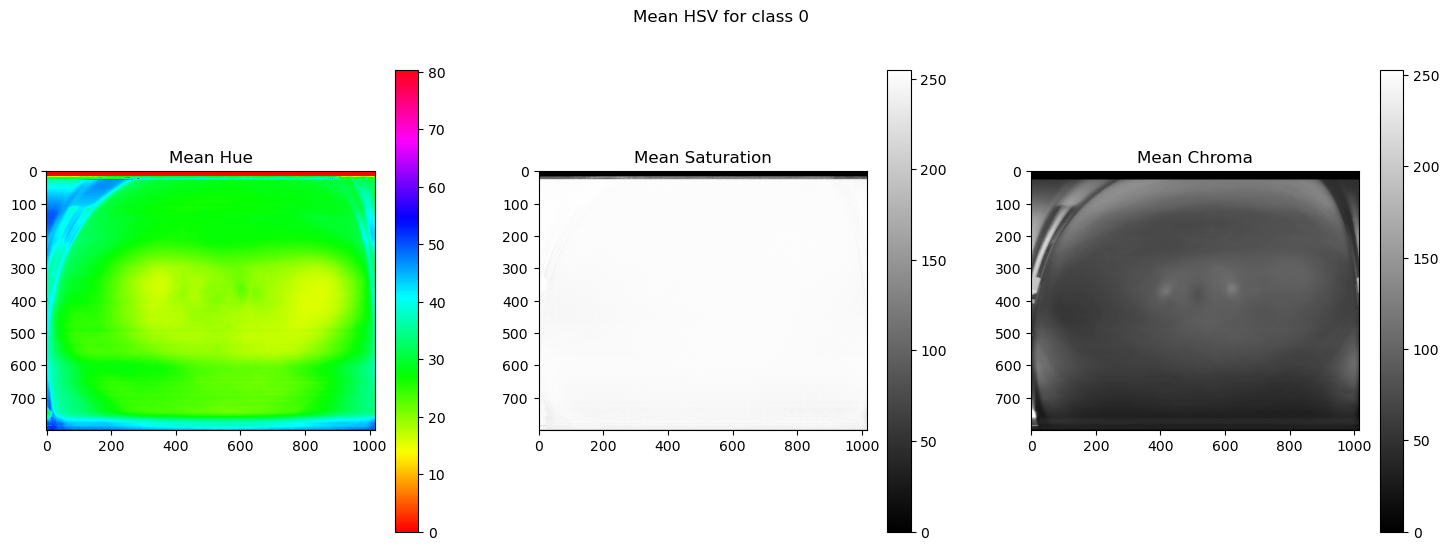

In [67]:
hue_array_0, saturation_array_0, chroma_array_0 = hsv(zero)
mean_hue_0, mean_saturation_0, mean_chroma_0 = mean_hsv(hue_array_0, saturation_array_0, chroma_array_0)
plot_hsv(mean_hue_0, mean_saturation_0, mean_chroma_0, ['Mean Hue', 'Mean Saturation', 'Mean Chroma'], 'Mean HSV for class 0')


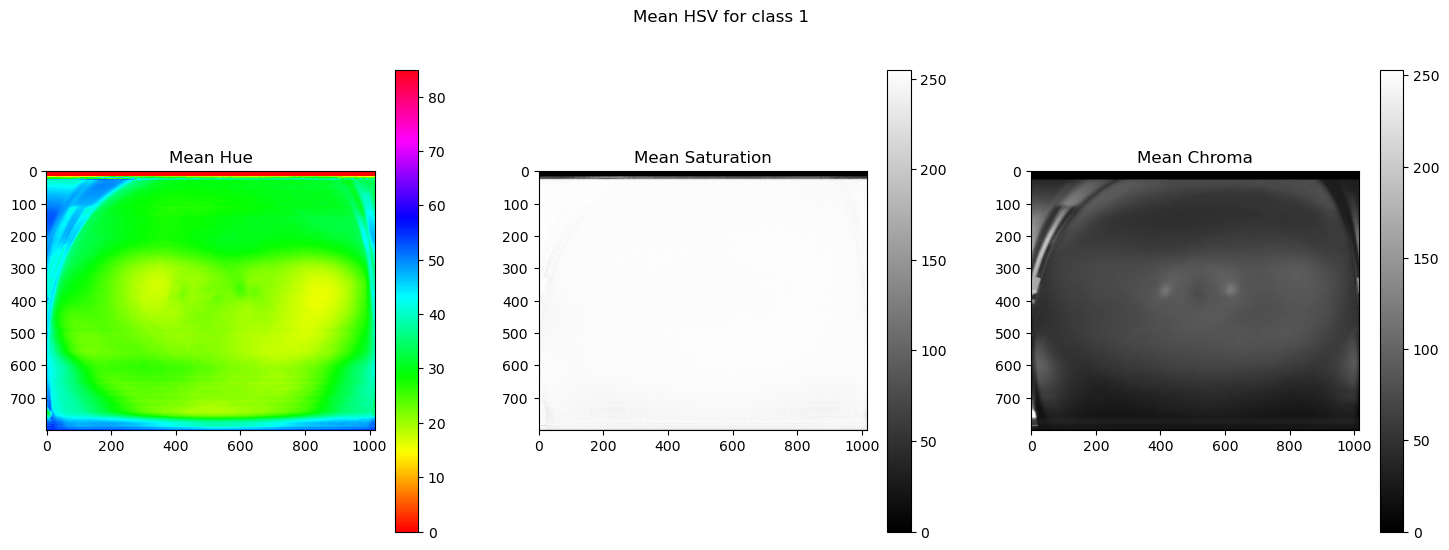

In [68]:
hue_array_1, saturation_array_1, chroma_array_1 = hsv(one)
mean_hue_1, mean_saturation_1, mean_chroma_1 = mean_hsv(hue_array_1, saturation_array_1, chroma_array_1)
plot_hsv(mean_hue_1, mean_saturation_1, mean_chroma_1, ['Mean Hue', 'Mean Saturation', 'Mean Chroma'], 'Mean HSV for class 1')

In [78]:
S

TypeError: 'tuple' object cannot be interpreted as an integer

TypeError: Invalid shape () for image data

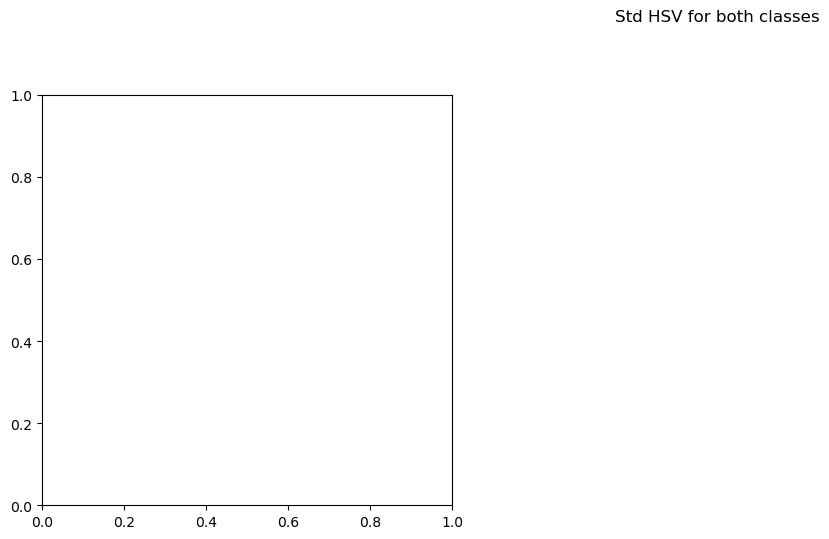

In [72]:
std_hue_combined = np.std(np.concatenate((mean_hue_0, mean_hue_1), axis=0))
std_saturation_combined = np.std(np.concatenate((mean_saturation_0, mean_saturation_1), axis=0), axis=0)
std_chroma_combined = np.std(np.concatenate((mean_chroma_0, mean_chroma_1), axis=0), axis=0)
plot_hsv(std_hue_combined, std_saturation_combined, std_chroma_combined, ['Std Hue', 'Std Saturation', 'Std Chroma'], 'Std HSV for both classes')

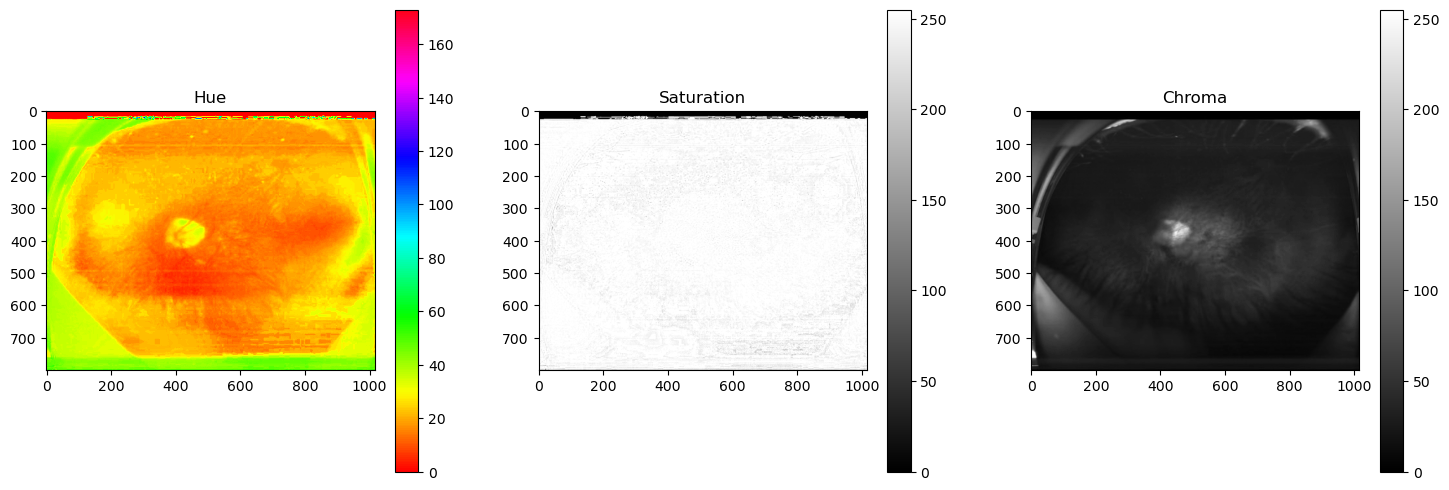

In [ ]:


# Visualize the average hue, saturation, and chroma for the first image as an example
example_index = 0
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(hue_array[example_index], cmap='hsv')
plt.title('Hue')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(saturation_array[example_index], cmap='gray')
plt.title('Saturation')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(chroma_array[example_index], cmap='gray')
plt.title('Chroma')
plt.colorbar()

plt.show()


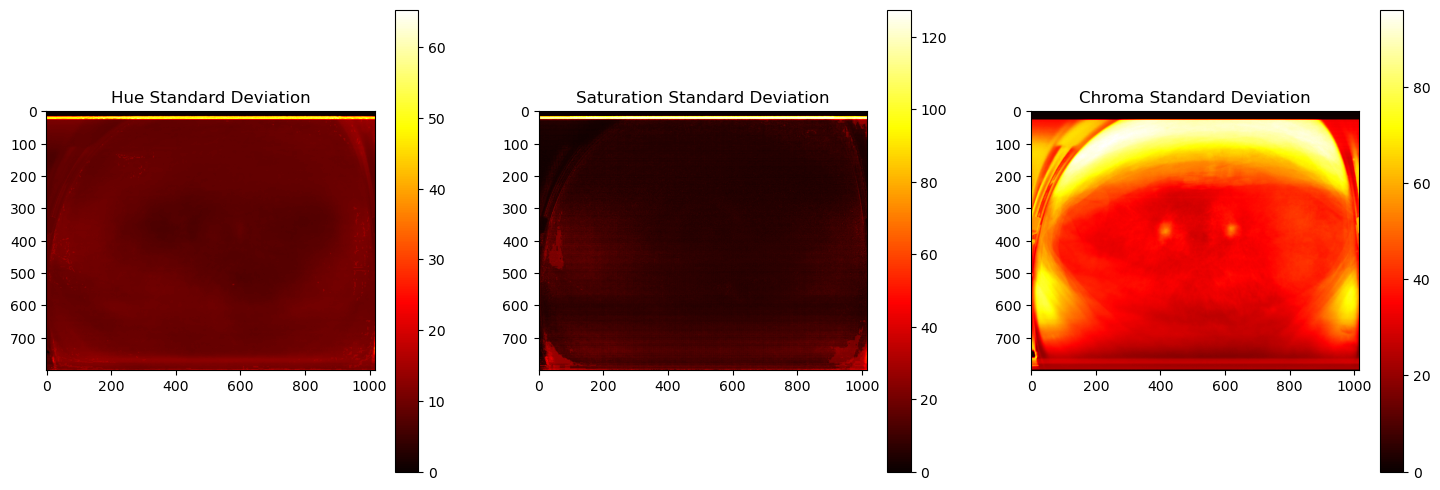

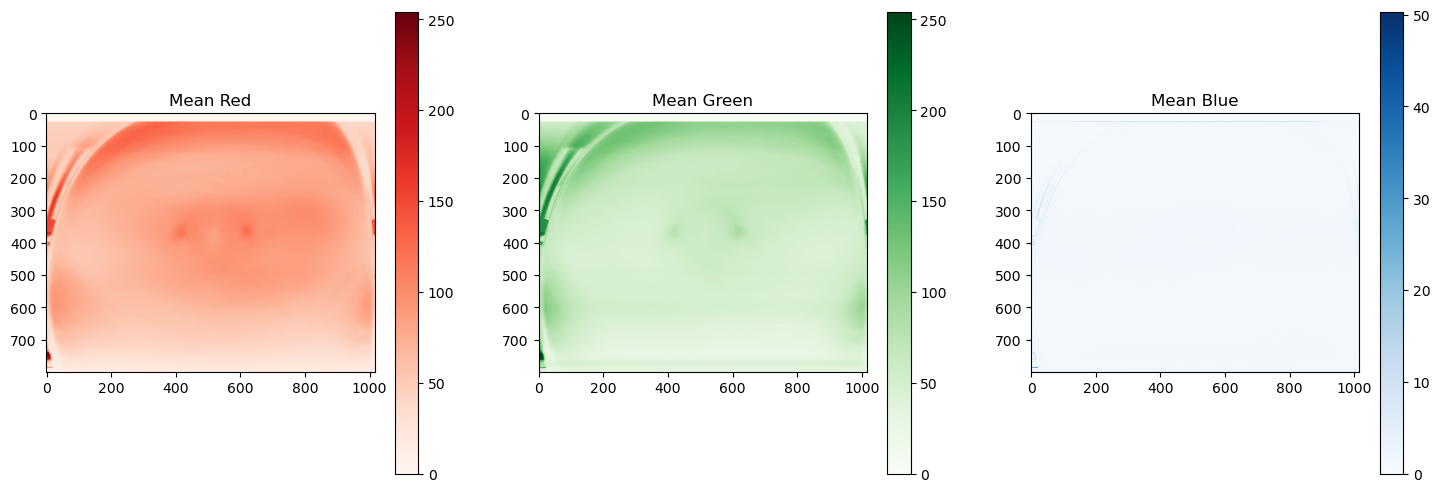

In [ ]:
red_list = []
green_list = []
blue_list = []

# Process each image
for img in data:
    red, green, blue = cv2.split(img)
    red_list.append(red)
    green_list.append(green)
    blue_list.append(blue)

red_array = np.array(red_list)
green_array = np.array(green_list)
blue_array = np.array(blue_list)


plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(np.mean(red_array, axis=0), cmap='Reds')
plt.title('Mean Red')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(np.mean(green_array, axis=0), cmap='Greens')
plt.title('Mean Green')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(np.mean(blue_array, axis=0), cmap='Blues')
plt.title('Mean Blue')
plt.colorbar()

plt.show()


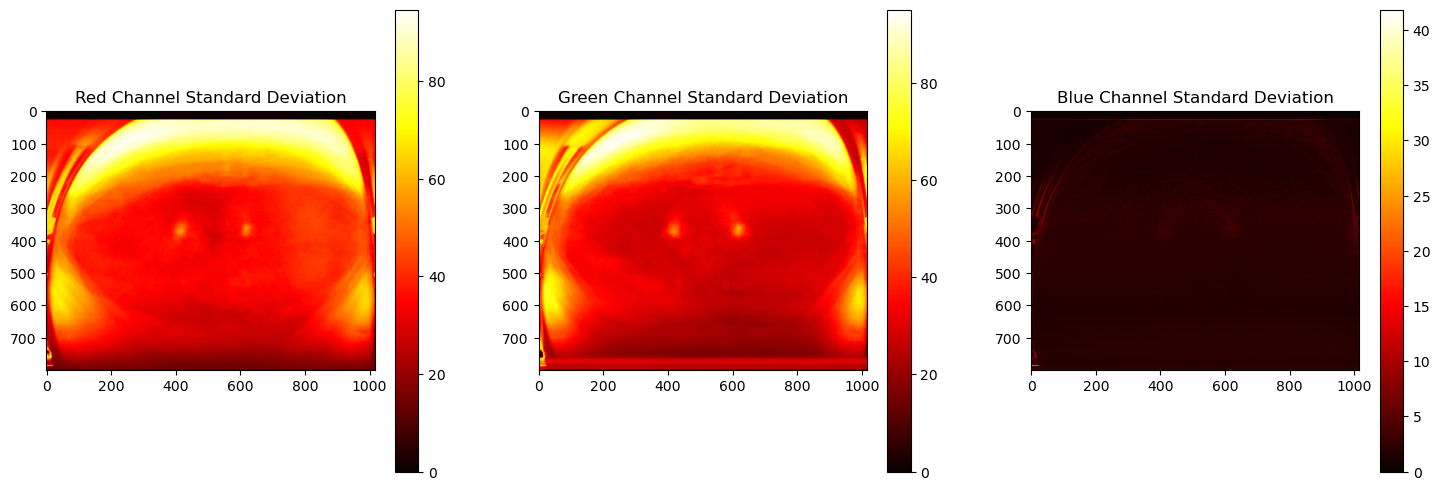

In [ ]:

# Plot the standard deviation maps
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(np.std(red_array, axis=0), cmap='hot')
plt.title('Red Channel Standard Deviation')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(np.std(green_array, axis=0), cmap='hot')
plt.title('Green Channel Standard Deviation')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(np.std(blue_array, axis=0), cmap='hot')
plt.title('Blue Channel Standard Deviation')
plt.colorbar()

plt.show()

In [ ]:
# perform a SVM classification on the data
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_curve, auc, roc_curve, confusion_matrix



In [ ]:
random_state = 42
kernel = "linear"
C = 1.0
test_size = 0.2

wandb.init(project="UWF4DR_Challenge", entity="pilsvera", name = "SVC")
wandb.config = {"model": "SVM", "kernel": kernel, "C": C, "random_state": random_state, "test_size": test_size}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(flattened_images_scaled, y, test_size=test_size, random_state=random_state)

In [ ]:
svm_model = SVC(kernel=kernel, probability=True, random_state=random_state)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]

SVC(kernel='linear', probability=True, random_state=42)

In [ ]:
def output(y_test, y_pred, y_pred_proba):
    # Classification report and accuracy
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy )

    # Calculate AUROC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("AUROC:", roc_auc)

    # Calculate AUPRC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    auprc = auc(recall, precision)
    print("AUPRC:", auprc)

    # Calculate sensitivity and specificity
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall curve
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % auprc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    wandb.log({"Accucary:": accuracy, "AUROC": roc_auc, "AUPRC": auprc, "senstivity": sensitivity, "specificity": specificity})



              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93        42
         1.0       0.00      0.00      0.00         5

    accuracy                           0.87        47
   macro avg       0.45      0.49      0.47        47
weighted avg       0.80      0.87      0.83        47

Accuracy: 0.8723404255319149
AUROC: 0.6714285714285715
AUPRC: 0.14033396840517584
Sensitivity: 0.0
Specificity: 0.9761904761904762


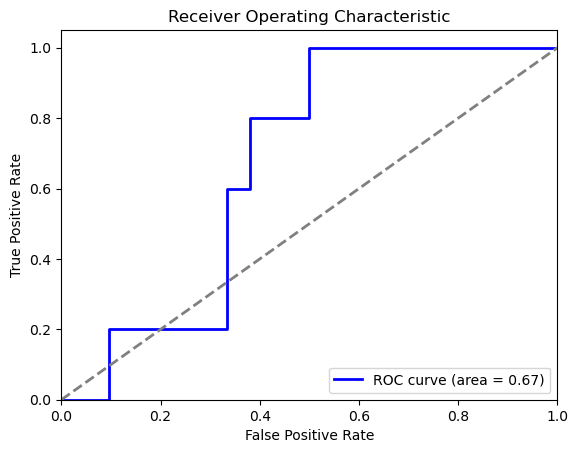

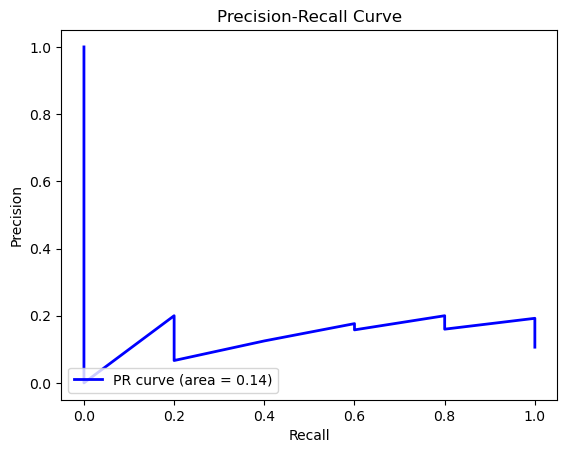

In [ ]:
output(y_test, y_pred, y_pred_proba)

In [ ]:
random_state = 42
kernel = "linear"
C = 1.0
test_size = 0.2

wandb.init(project="UWF4DR_Challenge", entity="pilsvera", name = "SVC")
wandb.config = {"model": "SVM", "kernel": kernel, "C": C, "random_state": random_state, "test_size": test_size}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pilsvera. Use `wandb login --relogin` to force relogin


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(flattened_images_scaled, y, test_size=test_size, random_state=random_state)

In [ ]:
model = SVC(kernel=kernel, class_weight={0: 1, 1: 10}, probability=True, random_state=random_state)
model.fit(X_train, y_train)

SVC(class_weight={0: 1, 1: 10}, kernel='linear', probability=True,
    random_state=42)

In [ ]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93        42
         1.0       0.00      0.00      0.00         5

    accuracy                           0.87        47
   macro avg       0.45      0.49      0.47        47
weighted avg       0.80      0.87      0.83        47

Accuracy: 0.8723404255319149
AUROC: 0.6714285714285715
AUPRC: 0.14033396840517584
Sensitivity: 0.0
Specificity: 0.9761904761904762


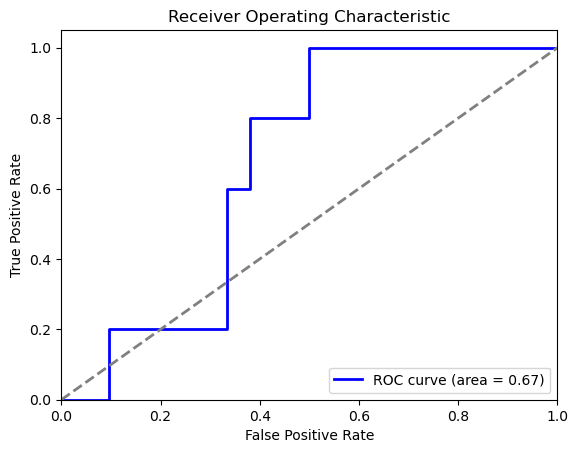

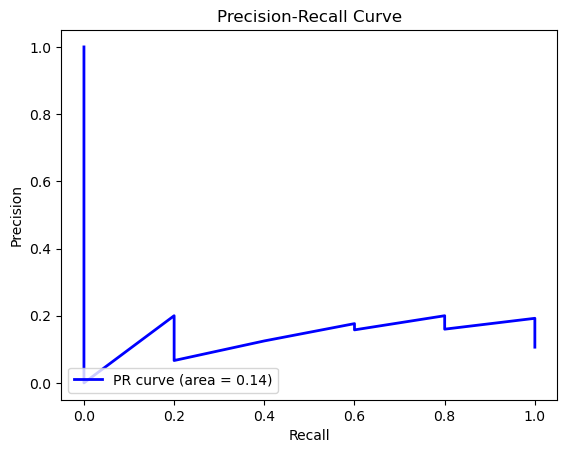

In [ ]:
output(y_test, y_pred, y_pred_proba)